In [249]:
import pandas as pd
import numpy as np
import math as m
import os
import collections
import csv
import random as rn
import seaborn as sns
import scipy.stats as stats
from itertools import islice
from scipy.stats import beta as beta
import matplotlib.pyplot as plt

# ------------------------------
# ----- PARAMETERS & SETUP -----
# ------------------------------

# Parameter setting

dataset_name = "seed_power_law_1"
authors_number = 20
months_number = 1
readers_classes = 30
shuffling = False
shuffle_number = 100

# Seed folder path

dataset_folder_path = "../data/{}/".format(dataset_name)
dataset_shuffle_folder_path = "../data/{}/shuffle/".format(dataset_name)
info_file_path = "{}info.csv".format(dataset_folder_path)
ratings_file_path = "{}ratings.csv".format(dataset_folder_path)
authors_file_path = "{}authors.csv".format(dataset_folder_path)
stats_file_path = "{}stats.csv".format(dataset_folder_path)

os.makedirs(dataset_folder_path, exist_ok=True)

print("DATASET NAME: ", dataset_name)
print("DATASET FOLDER PATH: ", dataset_folder_path)
print("INFO FILE PATH: ", info_file_path)
print("RATINGS FILE PATH: ", ratings_file_path)
print("AUTHORS FILE PATH: ", authors_file_path)

DATASET NAME:  seed_power_law_1
DATASET FOLDER PATH:  ../data/seed_power_law_1/
INFO FILE PATH:  ../data/seed_power_law_1/info.csv
RATINGS FILE PATH:  ../data/seed_power_law_1/ratings.csv
AUTHORS FILE PATH:  ../data/seed_power_law_1/authors.csv


---------- READERS DISTRIBUTION GENERATION STARTED ----------
Generated readers: 465
Distinct readers classes: 30 (i.e., m)
Total amount of ratings to generate:  99404
Minimum number of papers to generate: 1613
There are 1 readers which give 1613 ratings
There are 2 readers which give 980 ratings
There are 3 readers which give 698 ratings
There are 4 readers which give 555 ratings
There are 6 readers which give 446 ratings
There are 5 readers which give 445 ratings
There are 7 readers which give 392 ratings
There are 8 readers which give 346 ratings
There are 9 readers which give 331 ratings
There are 10 readers which give 312 ratings
Etc.
---------- READERS DISTRIBUTION GENERATION COMPLETED ----------


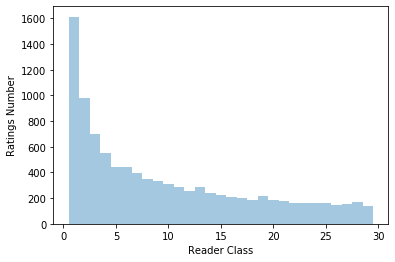

In [250]:
# ------------------------------
# ---- CORE IMPLEMENTATION -----
# ------------------------------

print("---------- READERS DISTRIBUTION GENERATION STARTED ----------")

# Return first n items of the iterable as a list

def take(n, iterable):
    return list(islice(iterable, n))

def truncated_power_law(a, m):
    x = np.arange(1, m+1, dtype='float')
    pmf = 1/x**a
    pmf /= pmf.sum()
    return stats.rv_discrete(values=(range(1, m+1), pmf))

a, m = .7, readers_classes
d = truncated_power_law(a=a, m=m)
n = 10000
sample = d.rvs(size=n)
ax = sns.distplot(sample, bins=np.arange(m)+0.5, kde=False)
ax.set(xlabel="Reader Class", ylabel= "Ratings Number")
fig = ax.get_figure()
path = "{}/power-law-readers.pdf".format(dataset_folder_path)
fig.savefig(path, bbox_inches='tight')

readers_number = int((m*(m+1))/2)
ratings_number = 0
reader_rating_frequency = list(collections.Counter(sample).most_common())
for readers_amount,rating_frequency in reader_rating_frequency:
    ratings_number += readers_amount * rating_frequency
min_papers_number = collections.Counter(sample).most_common()[0][1]
papers_number = min_papers_number

print(f"Generated readers: {readers_number}")
print(f"Distinct readers classes: {readers_classes} (i.e., m)")
print(f"Total amount of ratings to generate:  {ratings_number}")
print(f"Minimum number of papers to generate: {min_papers_number}")
for readers_amount, rating_frequency in take(10, reader_rating_frequency):
    print(f"There are {readers_amount} readers which give {rating_frequency} ratings")
print("Etc.")

# Setting up arrays

papers = np.arange(papers_number)
readers = np.arange(readers_number)
authors = np.arange(authors_number)

print("---------- READERS DISTRIBUTION GENERATION COMPLETED ----------")

In [251]:
# Papers distribution generation with beta distribution

print("---------- INTRA-PAPER DISTRIBUTIONS GENERATION STARTED ----------")

generated_configurations = {"0":{},"1":{},"2":{},"3":{},"4":{}}

beta_distributions_frequencies = [(0, int(round((5*papers_number/100))))]
beta_distributions_frequencies.append((1, int(round(30*papers_number/100))))
beta_distributions_frequencies.append((2, int(round(20*papers_number/100))))
beta_distributions_frequencies.append((3, int(round(30*papers_number/100))))
beta_distributions_frequencies.append((4, int(round(15*papers_number/100))))

papers_set = set(papers)
paper_distributions = [None] * papers_number

generated_papers_distributions = 0
for (index, papers_amount) in beta_distributions_frequencies:
    if papers_amount > len(papers_set):
        papers_amount = len(papers_set)
    current_paper_set = rn.sample(papers_set, papers_amount)
    generated_configurations["{}".format(index)]["papers_ids"] = current_paper_set
    generated_configurations["{}".format(index)]["papers_amount"] = papers_amount
    for paper in current_paper_set:
        a = 0
        b = 0
        if index==0:
            # CASE 1: a == b == 1, 5% of papers
            a = 1
            b = 1
        if index==1:
            # CASE 2: a == b > 1, 30% of papers
            a = rn.randint(2, 10)
            b = a
        if index == 2:
            # CASE 3: 0 < (a ^ b) < 1, 30% of papers
            a = rn.uniform(0.3, 1)
            b = rn.uniform(0.001, 1)
        if index == 3:
            # CASE 4: (a V b) == 1, (a > b V b > a), 20% of papers
            a = 1
            b = rn.randint(1, 10)
            if rn.randint(0,1) > 0.5:
                a, b = b, a
        if index == 4:
            # CASE 5: (a ^ b) > 1, (a > b V b > a), 15% of papers
            a = rn.randint(2, 10)
            b = rn.randint(2 + a, 10 + a)
            if rn.randint(0,1) > 0.5:
                a, b = b, a
        percentage = 100*generated_papers_distributions/papers_number
        if percentage % 10 == 0:
            print("{}/{} ({}/100%)".format(int(generated_papers_distributions), papers_number, int(percentage)))
        paper_distributions[paper] = [a, b]
        generated_papers_distributions = generated_papers_distributions + 1
        papers_set.remove(paper)
print("{}/{} (100/100%)".format(papers_number, papers_number))

print("---------- INTRA-PAPER DISTRIBUTIONS GENERATION COMPLETED ----------")

---------- INTRA-PAPER DISTRIBUTIONS GENERATION STARTED ----------
0/1613 (0/100%)
1613/1613 (100/100%)
---------- INTRA-PAPER DISTRIBUTIONS GENERATION COMPLETED ----------


In [252]:
print("---------- READERS SAMPLING STARTED ----------")

readers_configurations = []
# key: amount of ratings to generate, value: readers identifiers

samples_amount = 0
for readers_amount, rating_frequency in reader_rating_frequency:
    sampled_readers = np.random.choice(readers, readers_amount, False) 
    readers = np.setdiff1d(readers, sampled_readers)
    readers_configurations.append((readers_amount, rating_frequency, sampled_readers))
    percentage = round(100*samples_amount/readers_number)
    samples_amount += readers_amount
    print(f"Sampled Readers: {samples_amount} Remaining Readers: {len(readers)}")

print("---------- READERS SAMPLING COMPLETED ----------")

---------- READERS SAMPLING STARTED ----------
Sampled Readers: 1 Remaining Readers: 464
Sampled Readers: 3 Remaining Readers: 462
Sampled Readers: 6 Remaining Readers: 459
Sampled Readers: 10 Remaining Readers: 455
Sampled Readers: 16 Remaining Readers: 449
Sampled Readers: 21 Remaining Readers: 444
Sampled Readers: 28 Remaining Readers: 437
Sampled Readers: 36 Remaining Readers: 429
Sampled Readers: 45 Remaining Readers: 420
Sampled Readers: 55 Remaining Readers: 410
Sampled Readers: 68 Remaining Readers: 397
Sampled Readers: 79 Remaining Readers: 386
Sampled Readers: 91 Remaining Readers: 374
Sampled Readers: 105 Remaining Readers: 360
Sampled Readers: 120 Remaining Readers: 345
Sampled Readers: 139 Remaining Readers: 326
Sampled Readers: 155 Remaining Readers: 310
Sampled Readers: 172 Remaining Readers: 293
Sampled Readers: 192 Remaining Readers: 273
Sampled Readers: 210 Remaining Readers: 255
Sampled Readers: 231 Remaining Readers: 234
Sampled Readers: 259 Remaining Readers: 206
S

In [253]:
print("---------- RATINGS GENERATION STARTED ----------")

generated_ratings = 0
rated_papers = []
with open(ratings_file_path, mode='w', newline='') as ratings_file:
    ratings_writer = csv.writer(ratings_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    ratings_writer.writerow(['Timestamp', 'Reader', 'Paper', 'Score','Reader-Label'])
    for readers_amount, rating_frequency, sampled_readers in readers_configurations:    
        for reader in sampled_readers:
            sample = np.random.choice(papers, rating_frequency, False)     
            for paper in sample:    
                paper_distribution = beta(paper_distributions[paper][0],paper_distributions[paper][1])
                percentage = 100*generated_ratings/ratings_number
                if percentage % 10 == 0:
                    print("{}/{} ({}/100%)".format(int(generated_ratings), ratings_number, int(percentage)))
                generated_rating = round(paper_distribution.rvs(1)[0], 2)
                if generated_rating == 0:
                    generated_rating = 0.01
                ratings_writer.writerow([
                    generated_ratings, 
                    reader, 
                    paper, 
                    generated_rating,
                    "R#{}".format(reader)
                ])
                rated_papers.append(paper)
                generated_ratings+=1
    
    # Filling gaps
    readers = np.arange(readers_number)
    unrated_papers = set(papers) - set(rated_papers)    
    for paper in unrated_papers:
        for reader in np.random.choice(readers, 5, False):
            paper_distribution = paper_distributions[paper]
            generated_rating = round(paper_distribution.rvs(1)[0], 2)
            if generated_rating == 0:
                generated_rating = 0.01
                ratings_writer.writerow([
                    generated_ratings, 
                    reader, 
                    paper,
                    generated_rating,
                    "R#{}".format(reader)
                ])
                generated_ratings+=1
        
    print("{}/{} (100/100%)".format(ratings_number, ratings_number))
    
ratings_file.close()

paper_ratings = pd.read_csv(ratings_file_path)
paper_ratings = paper_ratings.sample(frac=1)
paper_ratings["Timestamp"] = range(len(paper_ratings))
paper_ratings.reset_index(drop=True, inplace=True)

paper_ratings.to_csv(ratings_file_path, index=False, header=True, sep=",")

print("---------- RATINGS GENERATION ENDED ----------")

---------- RATINGS GENERATION STARTED ----------
0/99404 (0/100%)
49702/99404 (50/100%)
99404/99404 (100/100%)
---------- RATINGS GENERATION ENDED ----------


In [254]:
# Authors file generation

print("---------- AUTHORS GENERATION STARTED ----------")

with open(authors_file_path, mode='w', newline='') as authors_file:
    authors_writer = csv.writer(authors_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    authors_writer.writerow(["Author", "Paper"])
    for index, author in enumerate(authors):
        percentage = 100*index/authors_number
        if percentage % 10 == 0:
            print("{}/{} ({}/100%)".format(int(index), authors_number, int(percentage)))
        # An author writes a number of paper between 1 and paper_fraction
        author_papers_number = rn.randint(1, (papers_number-1))
        papers_written = np.random.choice(papers, author_papers_number).tolist()
        papers_written = set(papers_written)
        if len(papers_written) > 1:
            papers_written = map(str, list(papers_written))
            papers_written = ";".join(papers_written)
        else:
            papers_written = list(papers_written)[0]
        authors_writer.writerow([author, papers_written])
    print("{}/{} (100/100%)".format(authors_number, authors_number))
authors_file.close()
        
print("---------- AUTHORS GENERATION ENDED ----------")

---------- AUTHORS GENERATION STARTED ----------
0/20 (0/100%)
2/20 (10/100%)
4/20 (20/100%)
6/20 (30/100%)
8/20 (40/100%)
10/20 (50/100%)
12/20 (60/100%)
14/20 (70/100%)
16/20 (80/100%)
18/20 (90/100%)
20/20 (100/100%)
---------- AUTHORS GENERATION ENDED ----------


In [255]:
# Info file generation

print("---------- INFO GENERATION STARTED ----------")

info_dataframe = pd.DataFrame(columns=["Dataset", "Paper", "Reader", "Rating", "Author"])
info_dataframe = info_dataframe.append(
    {
        "Dataset": dataset_name, 
        "Paper": papers_number, 
        "Reader": readers_number, 
        "Rating": ratings_number, 
        "Author": authors_number
    }, ignore_index=True)
info_dataframe.to_csv(info_file_path, index=False)

print("---------- INFO GENERATION ENDED ----------")

---------- INFO GENERATION STARTED ----------
---------- INFO GENERATION ENDED ----------


In [256]:
# Stats file generation

print("---------- STATS GENERATION STARTED ----------")

temp_ratings_dataframe = pd.read_csv(ratings_file_path)
temp_ratings_dataframe = temp_ratings_dataframe.loc[:, temp_ratings_dataframe.columns != "Reader-Label"]
temp_ratings_dataframe[temp_ratings_dataframe.columns] = temp_ratings_dataframe[temp_ratings_dataframe.columns].apply(pd.to_numeric)

stats_dataframe = temp_ratings_dataframe.copy()
stats_dataframe[stats_dataframe > 0.0000001] = 1

print("---------- COMPUTING STATS FOR PAPERS ----------")

sums_paper = stats_dataframe.copy().sum(axis=0)
sums_paper_dataframe = pd.DataFrame(sums_paper)

max_ratings_paper = sums_paper_dataframe.max()
min_ratings_paper = sums_paper_dataframe.min()
mean_ratings_paper = sums_paper_dataframe.mean()

temp_ratings_dataframe = temp_ratings_dataframe.T
paper_counter = 0
for index, row in temp_ratings_dataframe.iterrows():
    if len(np.unique(row)) == 1:
        paper_counter+=1
        
print("---------- COMPUTING STATS FOR READERS ----------")

sums_reader = stats_dataframe.copy().sum(axis=1)
counter=collections.Counter(sums_reader)
sums_reader_dataframe = pd.DataFrame(sums_reader)

max_ratings_reader = sums_reader_dataframe.max()
min_ratings_reader = sums_reader_dataframe.min()
mean_ratings_reader = sums_reader_dataframe.mean()

temp_ratings_dataframe = temp_ratings_dataframe
reader_counter = 0
for index, row in temp_ratings_dataframe.iterrows():
    if len(np.unique(row)) == 1:
        reader_counter+=1
        
# Writing stats to file

stats_dataframe = pd.DataFrame(columns=[
    "Dataset",
    "Max Number Rating Paper", 
    "Min Number Rating Paper", 
    "Mean Number Rating Paper",
    "Number Papers Unique Ratings",
    "Max Number Rating Reader", 
    "Min Number Rating Reader", 
    "Mean Number Rating Reader"
    "Number Readers Unique Rating"
])
stats_dataframe = stats_dataframe.append(
    {
        "Dataset": dataset_name, 
        "Max Number Rating Paper": int(max_ratings_paper.values[0]), 
        "Min Number Rating Paper": int(min_ratings_paper.values[0]), 
        "Number Papers Unique Ratings": paper_counter, 
        "Mean Number Rating Paper": int(mean_ratings_paper.values[0]), 
        "Max Number Rating Reader": int(max_ratings_reader.values[0]), 
        "Min Number Rating Reader": int(min_ratings_reader.values[0]), 
        "Mean Number Rating Reader": int(mean_ratings_reader.values[0]), 
        "Number Readers Unique Rating": reader_counter, 
    }, ignore_index=True)
stats_dataframe.to_csv(stats_file_path, index=False)

print("---------- STATS GENERATION COMPLETED ----------")

---------- STATS GENERATION STARTED ----------
---------- COMPUTING STATS FOR PAPERS ----------
---------- COMPUTING STATS FOR READERS ----------
---------- STATS GENERATION COMPLETED ----------


In [ ]:
# Data generation for experiments

# ------------------------------
# -- EXP 1-A: DATA GENERATION --
# ------------------------------

print("---------- SPECIAL RATINGS STARTED ----------")

gaussian_beta_distributions = generated_configurations["2"]
papers_identifiers = gaussian_beta_distributions["papers_ids"]
for paper in papers_identifiers:
    mean = (paper_distributions[paper][0]/(paper_distributions[paper][0] + paper_distributions[paper][1]))
    SR1_rating_id = generated_ratings
    SR1_reader = readers_number
    SR1_paper = paper
    SR1_rating_score = round(mean,2)
    SR1_reader_label = "SR#1"
    SR2_rating_id = generated_ratings+1
    SR2_reader = readers_number+1
    SR2_paper = paper
    SR2_reader_label = "SR#2"
    SR3_rating_id = generated_ratings+2
    SR3_reader = readers_number+2
    SR3_paper = paper
    SR3_reader_label = "SR#3"
    if mean <= 0.5:
        SR2_rating_score = 0.01
        SR3_rating_score = round(((1-mean)/2),2)
    else:
        SR2_rating_score = 1.0
        SR3_rating_score = round((mean/2),2)
    with open(ratings_file_path, mode='a', newline='') as ratings_file:
        ratings_writer = csv.writer(ratings_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        ratings_writer.writerow([SR1_rating_id, SR1_reader, SR1_paper, SR1_rating_score, SR1_reader_label])
        ratings_writer.writerow([SR2_rating_id, SR2_reader, SR2_paper, SR2_rating_score, SR2_reader_label])
        ratings_writer.writerow([SR3_rating_id, SR3_reader, SR3_paper, SR3_rating_score, SR3_reader_label])
    ratings_file.close()
    generated_ratings = generated_ratings + 3
ratings_number = generated_ratings
readers_number = readers_number + 3
    
# Updating info file

info_dataframe = pd.DataFrame(columns=["Dataset", "Paper", "Reader", "Rating", "Author"])
info_dataframe = info_dataframe.append(
    {
        "Dataset": dataset_name, 
        "Paper": papers_number, 
        "Reader": readers_number, 
        "Rating": ratings_number, 
        "Author": authors_number
    }, ignore_index=True)
info_dataframe.to_csv(info_file_path, index=False)

print("---------- SPECIAL RATINGS COMPLETED  ----------")

In [ ]:
# ------------------------------
# -- EXP 1-B: DATA GENERATION --
# ------------------------------

print("---------- RATINGS SHUFFLING STARTED ----------")

if shuffling:
    paper_ratings = pd.read_csv(ratings_file_path)
    os.makedirs(dataset_shuffle_folder_path, exist_ok=True)
    for s in range(shuffle_number):
        c = 0
        if s % 10 == 0:
            print("{}/{} ({}/100%)".format(s, shuffle_number, s))
        current_shuffle_file_path = "{}/shuffle_{}.csv".format(dataset_shuffle_folder_path, s)
        shuffled_papers_ratings = paper_ratings.sample(frac=1)
        for i, row in shuffled_papers_ratings.iterrows():
            shuffled_papers_ratings.at[i,'Timestamp'] = c
            c  = c + 1
        shuffled_papers_ratings.to_csv(current_shuffle_file_path, index=False, header=True, sep=",")
    print("{}/{} (100/100%)".format(shuffle_number, shuffle_number))
    
print("---------- RATINGS SHUFFLING COMPLETED ----------")
